In [1]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import numpy as np
import talib as ta
from datetime import timedelta, datetime
import time
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd
from vnpy.trader.utils import htmlplot

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2019-01-19 14:54:02.266074	开始回测
2019-01-19 14:54:02.266376	策略初始化
2019-01-19 14:54:02.665441	数据载入完成, 时间段:[20180528 08:00,20180601 12:00);数据量:6000
2019-01-19 14:54:02.665742	初始化预加载数据成功, 数据长度:6000
2019-01-19 14:54:02.665822	策略初始化完成
2019-01-19 14:54:02.665882	策略启动完成
2019-01-19 14:54:02.665970	回测时间范围:[20180601 12:00,20181201 12:00)
2019-01-19 14:54:02.666065	当前回放的时间段:[20180601 12:00,20181201 12:00)
2019-01-19 14:54:20.593143	数据载入完成, 时间段:[20180601 12:00,20181201 12:00);数据量:261728
2019-01-19 14:54:20.880526	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2019-01-19 14:54:21.754872	数据载入完成, 时间段:[20180523 00:45,20180531 20:50);数据量:12725
2019-01-19 14:54:21.758274	WARNING: 该时间段:[20180603 12:01,20180603 12:15) 数据量为0!
SHORT takeProfit:24.121849	Progress: 6%    
SHORT stopLoss54:24.842620	Progress: 9%    
SHORT takeProfit:25.355653	Progress: 11%    
SHORT takeProfit:25.607642	Progress: 12%    
SHORT stopLoss
SHORT stopLoss5

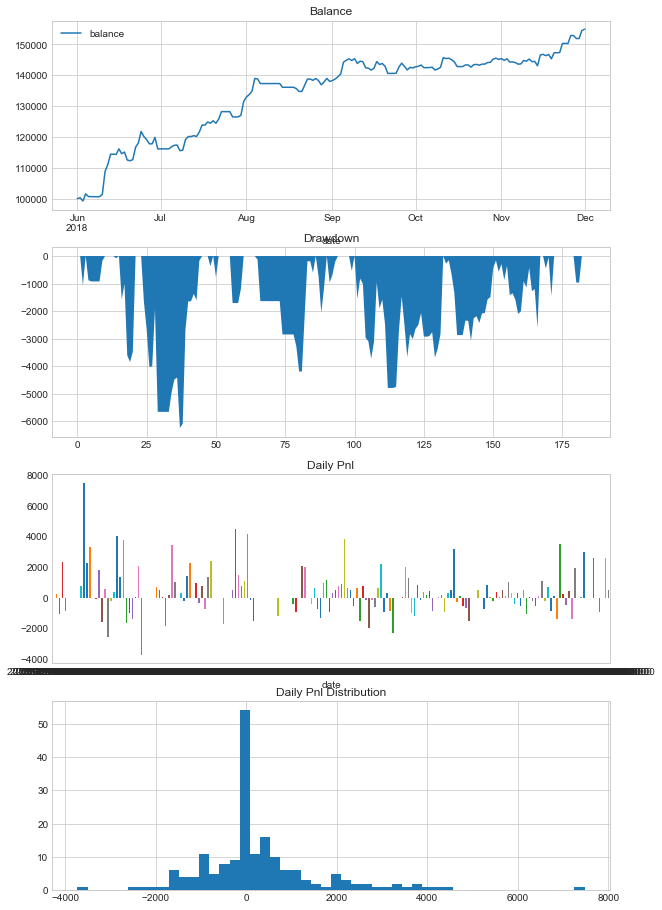

2019-01-19 14:54:50.625437	计算回测结果
2019-01-19 14:54:50.637483	交割单已生成
2019-01-19 14:54:50.637944	------------------------------
2019-01-19 14:54:50.638209	第一笔交易：	2018-06-06 00:00:00
2019-01-19 14:54:50.638330	最后一笔交易：	2018-12-01 11:58:00
2019-01-19 14:54:50.638397	总交易次数：	52
2019-01-19 14:54:50.638480	总盈亏：	54,935.66
2019-01-19 14:54:50.638565	最大回撤: 	-4,629.98
2019-01-19 14:54:50.638641	平均每笔盈利：	1,056.46
2019-01-19 14:54:50.638718	平均每笔滑点：	0.95
2019-01-19 14:54:50.638793	平均每笔佣金：	60.46
2019-01-19 14:54:50.638964	胜率		57.69%
2019-01-19 14:54:50.639025	盈利交易平均值	2,803.87
2019-01-19 14:54:50.639088	亏损交易平均值	-1,326.39
2019-01-19 14:54:50.639148	盈亏比：	2.11
2019-01-19 14:54:51.293269	策略回测统计图已保存


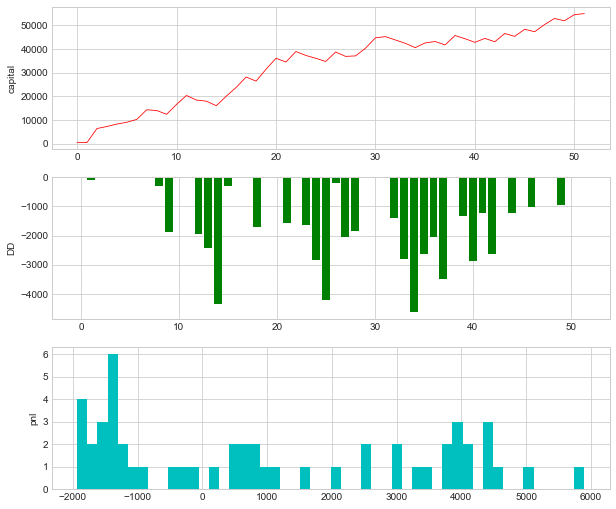

2019-01-19 14:54:51.677561	计算按日统计结果


In [4]:
class DIStrategy(CtaTemplate):
    """DIStrategy"""
    className = 'DIStrategy'
    author = 'yuanhongjian'
    # 策略参数（与参数列表对应）
    # 参数设置
    ShortMoMPeriod = 11
    LongMoMPeriod = 27
    
    lot = 10  # 设置手数
    
    # 仓位管理参数
    nPos = 0
    fixsize = 1
    Ratio = 0.02
    proportion = 2
    
    # 止盈止损参数
    stopRatio = 0.02
    
    # 策略变量（与变量列表对应）
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['ShortMoMPeriod','LongMoMPeriod',
                 'lot',
                 'nPos','fixsize','Ratio','proportion',
                'stopRatio']
    
    # 变量列表
    varList = ['transactionPrice']
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典（对应上面的策略变量）
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    # 过滤掉实盘推数据可能产生的阻塞(5s延迟)
    def dataBlock(self, dataTime, now, maxDelay=5):
        if abs(now - dataTime).total_seconds() > maxDelay:
            self.writeCtaLog(
                "数据推送阻塞,跳过该次推送:now=%s,dataTime=%s" % (now.strftime("%Y-%m-%d %H:%M:%S"),
                                                      dataTime.strftime("%Y-%m-%d %H:%M:%S")))
            return True
        else:
            return False
        
    def onBar(self, bar):
        """收到Bar推送"""
    
        self.onBarStopLoss(bar)
        self.onBarfixedaddposition(bar)
        
    def onBarfixedaddposition(self, bar):
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]
    # 固定损失加仓激进版模块______________________________________
        if (self.posDict[symbol+'_LONG']!=0 and self.nPos < 4):    # 持有多头仓位并且加仓次数不超过4次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if lastOrder/bar.close-1 >= self.Ratio/self.proportion: 
                    self.sell(symbol,bar.close*0.98, self.posDict[symbol+'_LONG'])
            if bar.close/lastOrder-1>= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.buy(symbol,bar.close*1.02, add_fixsize)  # 加仓数量
                self.fixsize = add_fixsize + self.fixsize
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 4):    # 持有空头仓位并且加仓次数不超过4次
            if self.nPos >= 1: # 上一次的加仓亏损达到原来盈利比例的 1/proportion 倍
                if bar.close/lastOrder-1>= self.Ratio/self.proportion:
                    self.cover(symbol,bar.close*1.02, self.posDict[symbol+'_SHORT'])
            if lastOrder/bar.close-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                add_fixsize = self.fixsize*self.proportion - self.fixsize
                self.short(symbol,bar.close*0.98,self.fixsize)  # 目标仓位100手，分别加仓25手、20手、15手，10手
                self.fixsize = add_fixsize + self.fixsize       
        
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        lastOrder=self.transactionPrice[symbol]
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+3*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-3*self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
        # 发出状态更新事件
        self.putEvent()    
        
    def on15MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "15m") # 获取历史数组
        
        if not am.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        # 指标计算
    
        MoMShort = ta.MOM(am.close, self.ShortMoMPeriod)
        MoMlong = ta.MOM(am.close, self.LongMoMPeriod)
        Stdlong = ta.STDDEV(am.close, self.LongMoMPeriod, nbdev=1)
        
        # 现象条件
        
        DI = MoMShort[-1] * MoMlong[-1] / (Stdlong[-1])**2
        BuyDI = (DI < -8) and (MoMlong[-1] > 0)
        SellDI = (DI < -4) and (MoMlong[-1] < 0)
        
            # 构建进出场逻辑-------------------------------------------------
        if BuyDI and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.lot)
        
        elif SellDI and (self.posDict[symbol + "_SHORT"] == 0):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.99, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.99, self.lot)
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass
    
def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)
    engine.setDatabase('VnTrader_1Min_Db')
    engine.setStartDate(startDate, initHours=100)
    engine.setEndDate(endDate)
    engine.setSlippage(slippage)
    engine.setRate(rate)
    engine.setLog(True)
    
#   在这里设置画图参数，目前只用设置freqency，支持的有 s(second) m(minute) h(hour) d(day)，也可以用timestamp, 例如： 1h -> timestamp(hours=1)
#   sample(输出用4hbar画图)
#   画图需要安装bokeh==0.12.14
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
#    htmlplot.showTransaction(engine, frequency="1h")
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('tradeDatetime')
    return engine
#     return perfromanceDf, tradeDf

runBacktesting(DIStrategy, {'symbolList': [
                                                    'BTCUSDT:binance',
#                                                             'eos_quarter:OKEX'
                                                        ]},
                                                           '20180601 12:00', 
#                                                               '20181006 12:00', 
                                                           '20181201 12:00',0.05, 5/10000)